When running on a fresh cloud instance, run these two cells , then restart the kernel:

In [1]:
!pip install -r ControlNet-XS/requirements/pt2.txt -qq
!pip install -e ControlNet-XS -qq

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'ControlNet-XS/requirements/pt2.txt'
ERROR: ControlNet-XS is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).


___

In [2]:
from functools import partial
from typing import Iterable
from abc import abstractmethod

import numpy as np

import torch
import torch as th
import torch.nn as nn

from torchvision import transforms as tt

from einops import rearrange

In [3]:
from sgm.modules.diffusionmodules.util import (
    conv_nd,
    linear,
    zero_module,
    timestep_embedding,
    checkpoint
)

from sgm.modules.attention import BasicTransformerBlock
from sgm.modules.diffusionmodules.openaimodel import (
    UNetModel,
    Timestep,
    ResBlock as ResBlock_orig,
    Downsample,
    Upsample,
    AttentionBlock,
)
from sgm.modules.diffusionmodules.twoStreamControl import ControlledXLUNetModel, ResBlock

from sgm.util import default, exists

ModuleNotFoundError: No module named 'sgm'

In [ ]:
class TimestepBlock(nn.Module):
    """Any module where forward() takes timestep embeddings as a second argument."""
    @abstractmethod
    def forward(self, x, emb): pass # Apply the module to `x` given `emb` timestep embeddings.

class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """A sequential module that passes timestep embeddings to the children that support it as an extra input."""
    def forward(self, x, emb, context=None, skip_time_mix=False, time_context=None, num_video_frames=None, time_context_cat=None, use_crossframe_attention_in_spatial_layers=False):
        for layer in self:
            if isinstance(layer, TimestepBlock): x = layer(x, emb)
            elif isinstance(layer, SpatialTransformer): x = layer(x, context)
            elif layer.__class__.__name__ == 'SpatialTransformer': x = layer(x, context)
            else: x = layer(x)
        return x

In [ ]:
class TwoStreamControlNet(nn.Module):

    def __init__(
            self,
            in_channels, model_channels, out_channels, hint_channels,
            num_res_blocks,
            attention_resolutions,
            dropout=0,
            channel_mult=(1, 2, 4, 8),
            conv_resample=True,
            dims=2,
            use_checkpoint=False,
            use_fp16=False,
            num_heads=-1, num_head_channels=-1, num_heads_upsample=-1,
            use_scale_shift_norm=False,
            resblock_updown=False,
            use_new_attention_order=False,
            adm_in_channels=None,
            use_spatial_transformer=False,  # custom transformer support
            transformer_depth=1,  # custom transformer support
            context_dim=None,  # custom transformer support
            n_embed=None,  # custom support for prediction of discrete ids into codebook of first stage vq model
            legacy=False,
            spatial_transformer_attn_type="softmax",
            use_linear_in_transformer=False,
            num_classes=None,
            control_model_ratio=1.0,    # ratio of the control model size compared to the base model. [0, 1]
            base_model=None,
            learn_embedding=False,
            control_mode='canny',
        ):
        # Umer: Let's fix some params to make the code easier
        infusion2control = 'cat' # how to infuse intermediate information into the control net? {'add', 'cat', None}
        infusion2base = 'add'    # how to infuse intermediate information into the base net? {'add', 'cat'}
        guiding='encoder',       # use just encoder for control or the whole encoder + decoder net? {'encoder', 'encoder_double', 'full'}
        two_stream_mode='cross', # mode for the two stream infusion. {'cross', 'sequential'}
        # # #
            
        super().__init__()
        
        self.control_mode = control_mode
        self.learn_embedding = learn_embedding
        self.infusion2control = infusion2control
        self.infusion2base = infusion2base
        self.in_ch_factor = 1 if infusion2control == 'add' else 2
        self.guiding = guiding
        self.two_stream_mode = two_stream_mode
        self.control_model_ratio = control_model_ratio
        self.out_channels = out_channels
        self.dims = 2
        self.model_channels = model_channels
        self.no_control = False
        self.control_scale = 1.0
    
        self.hint_model = None
        
        ################# start control model variations #################
        if base_model is None:
            base_model = UNetModel(
                adm_in_channels=adm_in_channels, num_classes=num_classes, use_checkpoint=use_checkpoint,
                in_channels=in_channels, out_channels=out_channels, model_channels=model_channels,
                attention_resolutions=attention_resolutions, num_res_blocks=num_res_blocks,
                channel_mult=channel_mult, num_head_channels=num_head_channels, use_spatial_transformer=use_spatial_transformer,
                use_linear_in_transformer=use_linear_in_transformer, transformer_depth=transformer_depth,
                context_dim=context_dim, spatial_transformer_attn_type=spatial_transformer_attn_type,
                legacy=legacy, dropout=dropout,
                conv_resample=conv_resample, dims=dims, use_fp16=use_fp16, num_heads=num_heads,
                num_heads_upsample=num_heads_upsample, use_scale_shift_norm=use_scale_shift_norm,
                resblock_updown=resblock_updown, use_new_attention_order=use_new_attention_order,
                n_embed=n_embed,
            )
    
        self.control_model = ControlledXLUNetModel(
            adm_in_channels=adm_in_channels, num_classes=num_classes, use_checkpoint=use_checkpoint,
            in_channels=in_channels, out_channels=out_channels, model_channels=model_channels,
            attention_resolutions=attention_resolutions, num_res_blocks=num_res_blocks,
            channel_mult=channel_mult, num_head_channels=num_head_channels, use_spatial_transformer=use_spatial_transformer,
            use_linear_in_transformer=use_linear_in_transformer, transformer_depth=transformer_depth,
            context_dim=context_dim, spatial_transformer_attn_type=spatial_transformer_attn_type,
            legacy=legacy, dropout=dropout,
            conv_resample=conv_resample, dims=dims, use_fp16=use_fp16, num_heads=num_heads,
            num_heads_upsample=num_heads_upsample, use_scale_shift_norm=use_scale_shift_norm,
            resblock_updown=resblock_updown, use_new_attention_order=use_new_attention_order,
            n_embed=n_embed,
            infusion2control=infusion2control,
            guiding=guiding, two_stream_mode=two_stream_mode, control_model_ratio=control_model_ratio,
        )
    
        self.diffusion_model = base_model
        ################# end control model variations #################
    
        self.enc_zero_convs_out = nn.ModuleList([])
        self.enc_zero_convs_in = nn.ModuleList([])
    
        self.middle_block_out = nn.ModuleList([])
        self.middle_block_in = nn.ModuleList([])
    
        self.dec_zero_convs_out = nn.ModuleList([])
        self.dec_zero_convs_in = nn.ModuleList([])
    
        ch_inout_ctr = {'enc': [], 'mid': [], 'dec': []}
        ch_inout_base = {'enc': [], 'mid': [], 'dec': []}
    
        ################# Gather Channel Sizes #################
        for module in self.control_model.input_blocks:
            if isinstance(module[0], nn.Conv2d):
                ch_inout_ctr['enc'].append((module[0].in_channels, module[0].out_channels))
            elif isinstance(module[0], (ResBlock, ResBlock_orig)):
                ch_inout_ctr['enc'].append((module[0].channels, module[0].out_channels))
            elif isinstance(module[0], Downsample):
                ch_inout_ctr['enc'].append((module[0].channels, module[-1].out_channels))
    
        for module in base_model.input_blocks:
            if isinstance(module[0], nn.Conv2d):
                ch_inout_base['enc'].append((module[0].in_channels, module[0].out_channels))
            elif isinstance(module[0], (ResBlock, ResBlock_orig)):
                ch_inout_base['enc'].append((module[0].channels, module[0].out_channels))
            elif isinstance(module[0], Downsample):
                ch_inout_base['enc'].append((module[0].channels, module[-1].out_channels))
    
        ch_inout_ctr['mid'].append((self.control_model.middle_block[0].channels, self.control_model.middle_block[-1].out_channels))
        ch_inout_base['mid'].append((base_model.middle_block[0].channels, base_model.middle_block[-1].out_channels))
    
        # guiding == 'encoder'
    
        for module in base_model.output_blocks:
            if isinstance(module[0], nn.Conv2d):
                ch_inout_base['dec'].append((module[0].in_channels, module[0].out_channels))
            elif isinstance(module[0], (ResBlock, ResBlock_orig)):
                ch_inout_base['dec'].append((module[0].channels, module[0].out_channels))
            elif isinstance(module[-1], Upsample):
                ch_inout_base['dec'].append((module[0].channels, module[-1].out_channels))
    
        self.ch_inout_ctr = ch_inout_ctr
        self.ch_inout_base = ch_inout_base
    
        ################# Build zero convolutions #################
        # two_stream_mode == 'cross'
        ################# cross infusion #################
        # infusion2control == 'cat'  (ie processing full concatenation (all output layers are concatenated without "slimming"))
        for ch_io_base in ch_inout_base['enc']:
            self.enc_zero_convs_in.append(self.make_zero_conv(
                in_channels=ch_io_base[1], out_channels=ch_io_base[1])
            )
            # guiding == 'encoder'
    
    
        # infusion2base (- consider all three guidings) == 'add'
        self.middle_block_out = self.make_zero_conv(ch_inout_ctr['mid'][-1][1], ch_inout_base['mid'][-1][1])
        
        # guiding == 'encoder'
        self.dec_zero_convs_out.append(
            self.make_zero_conv(ch_inout_ctr['enc'][-1][1], ch_inout_base['mid'][-1][1])
        )
        for i in range(1, len(ch_inout_ctr['enc'])):
            self.dec_zero_convs_out.append(
                self.make_zero_conv(ch_inout_ctr['enc'][-(i + 1)][1], ch_inout_base['dec'][i - 1][1])
            )
    
        
        self.input_hint_block = TimestepEmbedSequential(
            conv_nd(dims, hint_channels, 16, 3, padding=1),
            nn.SiLU(),
            conv_nd(dims, 16, 16, 3, padding=1),
            nn.SiLU(),
            conv_nd(dims, 16, 32, 3, padding=1, stride=2),
            nn.SiLU(),
            conv_nd(dims, 32, 32, 3, padding=1),
            nn.SiLU(),
            conv_nd(dims, 32, 96, 3, padding=1, stride=2),
            nn.SiLU(),
            conv_nd(dims, 96, 96, 3, padding=1),
            nn.SiLU(),
            conv_nd(dims, 96, 256, 3, padding=1, stride=2),
            nn.SiLU(),
            zero_module(conv_nd(dims, 256, int(model_channels * control_model_ratio), 3, padding=1))
        )
    
        scale_list = [1.] * len(self.enc_zero_convs_out) + [1.] + [1.] * len(self.dec_zero_convs_out)
        self.register_buffer('scale_list', torch.tensor(scale_list))

    def make_zero_conv(self, in_channels, out_channels=None):
        self.in_channels = in_channels
        self.out_channels = out_channels or in_channels
        return TimestepEmbedSequential(
            zero_module(conv_nd(self.dims, in_channels, out_channels, 1, padding=0))
        )

---

The goal is to manually execute and play with the code creating the extra connections between base and control.

Let's first create a base and a control model

In [ ]:
def cls_name(obj, full=False):
    cls_str = str(type(obj)).split("'")[1]
    if not full: cls_str = cls_str.split('.')[-1]
    return cls_str

In [ ]:
param_dict = {
    'adm_in_channels': 2816,
    'num_classes': 'sequential',
    'use_checkpoint': True,
    'in_channels': 4,
    'out_channels': 4,
    'hint_channels': 3,
    'model_channels': 320,
    'attention_resolutions': [4, 2],
    'num_res_blocks': 2,
    'channel_mult': [1, 2, 4],
    'num_head_channels': 64,
    'use_spatial_transformer': True,
    'use_linear_in_transformer': True,
    'transformer_depth': [1, 2, 10],
    'context_dim': 2048,
    'spatial_transformer_attn_type': 'softmax-xformers',
    'legacy': False,
    # # # # fixed for simplifying
    # 'infusion2control': 'cat',
    # 'guiding': 'encoder_double',
    # 'two_stream_mode': 'cross',
    # # # 
    'control_model_ratio': 0.1,
    'learn_embedding': True
}

default_param_dicts = {
    'dropout': 0,
    'channel_mult': (1, 2, 4, 8),
    'conv_resample': True,
    'dims': 2,
    'use_checkpoint': False,
    'use_fp16': False,
    'num_heads': -1,
    'num_head_channels': -1,
    'num_heads_upsample': -1,
    'use_scale_shift_norm': False,
    'resblock_updown': False,
    'use_new_attention_order': False,
    'adm_in_channels': None,
    'use_spatial_transformer': False,
    'transformer_depth': 1,
    'context_dim': None,
    'n_embed': None,
    'legacy': False,
    'spatial_transformer_attn_type': "softmax",
    'use_linear_in_transformer': False,
    'num_classes': None,
    'infusion2control': 'cat',
    'infusion2base': 'add',
    'guiding': 'encoder',
    'two_stream_mode': 'cross',
    'control_model_ratio': 1.0,
    'base_model': None,
    'learn_embedding': False,
    'control_mode': 'canny'
}

In [ ]:
for key, value in default_param_dicts.items():
    globals()[key] = value

for key, value in param_dict.items():
    globals()[key] = value

In [ ]:
base_model = UNetModel(
    adm_in_channels=adm_in_channels, num_classes=num_classes, use_checkpoint=use_checkpoint,
    in_channels=in_channels, out_channels=out_channels, model_channels=model_channels,
    attention_resolutions=attention_resolutions, num_res_blocks=num_res_blocks,
    channel_mult=channel_mult, num_head_channels=num_head_channels, use_spatial_transformer=use_spatial_transformer,
    use_linear_in_transformer=use_linear_in_transformer, transformer_depth=transformer_depth,
    context_dim=context_dim, spatial_transformer_attn_type=spatial_transformer_attn_type,
    legacy=legacy, dropout=dropout,
    conv_resample=conv_resample, dims=dims, use_fp16=use_fp16, num_heads=num_heads,
    num_heads_upsample=num_heads_upsample, use_scale_shift_norm=use_scale_shift_norm,
    resblock_updown=resblock_updown, use_new_attention_order=use_new_attention_order,
    n_embed=n_embed,
);

In [ ]:
control_model = ControlledXLUNetModel(
    adm_in_channels=adm_in_channels, num_classes=num_classes, use_checkpoint=use_checkpoint,
    in_channels=in_channels, out_channels=out_channels, model_channels=model_channels,
    attention_resolutions=attention_resolutions, num_res_blocks=num_res_blocks,
    channel_mult=channel_mult, num_head_channels=num_head_channels, use_spatial_transformer=use_spatial_transformer,
    use_linear_in_transformer=use_linear_in_transformer, transformer_depth=transformer_depth,
    context_dim=context_dim, spatial_transformer_attn_type=spatial_transformer_attn_type,
    legacy=legacy, dropout=dropout,
    conv_resample=conv_resample, dims=dims, use_fp16=use_fp16, num_heads=num_heads,
    num_heads_upsample=num_heads_upsample, use_scale_shift_norm=use_scale_shift_norm,
    resblock_updown=resblock_updown, use_new_attention_order=use_new_attention_order,
    n_embed=n_embed,
    infusion2control=infusion2control,
    guiding=guiding, two_stream_mode=two_stream_mode, control_model_ratio=control_model_ratio,
)

### Let's understand how relevant channel sizes are gathered

In [ ]:
ch_inout_ctr = {'enc': [], 'mid': [], 'dec': []}
ch_inout_base = {'enc': [], 'mid': [], 'dec': []}

We're using `module[0]` below, because each module is wrapped in a `TimestepEmbedSequential`:

In [ ]:
for module in control_model.input_blocks: print(cls_name(module,full=True))

Most module have 1 components only. Some ResBlocks have 2.

In [ ]:
for module in control_model.input_blocks: print(f'1st: {cls_name(module[0])} | Last: {cls_name(module[-1])} | len = {len(module)}')

In [ ]:
for module in base_model.input_blocks: print(f'1st: {cls_name(module[0])} | Last: {cls_name(module[-1])} | len = {len(module)}')

In [ ]:
def describe_appending(module, n1, n2): print(f'{cls_name(module):12}--> appending ({n1:4},{n2:4})')        

In [ ]:
ch_inout_ctr['enc'] = []

for module in control_model.input_blocks:
    if isinstance(module[0], nn.Conv2d):
        ch_inout_ctr['enc'].append((module[0].in_channels, module[0].out_channels))
        describe_appending(module[0], module[0].in_channels, module[0].out_channels)        
    elif isinstance(module[0], (ResBlock, ResBlock_orig)):
        ch_inout_ctr['enc'].append((module[0].channels, module[0].out_channels))
        describe_appending(module[0], module[0].channels, module[0].out_channels)        
    elif isinstance(module[0], Downsample):
        ch_inout_ctr['enc'].append((module[0].channels, module[-1].out_channels))
        describe_appending(module[0], module[0].channels, module[-1].out_channels) 
    else: print(f'- skipping {cls_name(module[0], full=True)}')

In [ ]:
ch_inout_ctr['enc']

**Q:** What do the first numbers mean? I would have expected the n_channel_out of a module to be the n_channel_in of the next moduel

In [ ]:
control_model.input_blocks[0][0]

In [ ]:
control_model.input_blocks[1][0]

Aha! The last blocks output (`32` from `Conv2d`) is indeed the input into the next block's first module (`GroupNorm`). The `GroupNorm`, however, goes from `32` to` 352` channels, which is what's saved into `ch_inout_ctr['enc']`.

**Edit: No**, `GroupNorm(32, 352)` means `GroupNorm` is applied to `352` channels and `32` groups are used (so that normalization is done over `352/32` channels).

In [ ]:
ch_inout_base['enc'] = []

for module in base_model.input_blocks:
    if isinstance(module[0], nn.Conv2d):
        ch_inout_base['enc'].append((module[0].in_channels, module[0].out_channels))
        describe_appending(module[0], module[0].in_channels, module[0].out_channels)        
    elif isinstance(module[0], (ResBlock, ResBlock_orig)):
        ch_inout_base['enc'].append((module[0].channels, module[0].out_channels))
        describe_appending(module[0], module[0].channels, module[0].out_channels)   
    elif isinstance(module[0], Downsample):
        ch_inout_base['enc'].append((module[0].channels, module[-1].out_channels))
        describe_appending(module[0], module[0].channels, module[-1].out_channels)  
    else: print(f'- skipping {cls_name(module[0], full=True)}') 

Aha! (This time for real!) In the base net, the channels line up. In the control net, the channels are the sum of the channels of the previous blocks of control net plus channels from the previous block of base net.

Let's check:

In [ ]:
for m1, m2 in zip(base_model.input_blocks, control_model.input_blocks):
    if isinstance(m1[0], nn.Conv2d):
        print(f'[base] {cls_name(m1[0]):12} --> ({m1[0].in_channels:4},{m1[0].out_channels:4}) | ({m2[0].in_channels:4},{m2[0].out_channels:4}) <-- {cls_name(m2[0]):>12} [control]')                
    elif isinstance(m1[0], (ResBlock, ResBlock_orig)):
        print(f'[base] {cls_name(m1[0]):12} --> ({m1[0].channels:4},{m1[0].out_channels:4}) | ({m2[0].channels:4},{m2[0].out_channels:4}) <-- {cls_name(m2[0]):>12} [control]')                
    elif isinstance(m1[0], Downsample):
        print(f'[base] {cls_name(m1[0]):12} --> ({m1[0].channels:4},{m1[-1].out_channels:4}) | ({m2[0].channels:4},{m2[-1].out_channels:4}) <-- {cls_name(m2[0]):>12} [control]')                
    else: print(f'- skipping {cls_name(module[0], full=True)}') 

Yes, looks good.

In [ ]:
ch_inout_ctr['mid'].append((control_model.middle_block[0].channels, control_model.middle_block[-1].out_channels))
ch_inout_base['mid'].append((base_model.middle_block[0].channels, base_model.middle_block[-1].out_channels))

In [ ]:
print(ch_inout_base['mid'], ch_inout_ctr['mid'])

**Q:** Iiuc, if the original images has size `w*h*3`, the bottleneck in the unet has size $\frac{w}{2^3} \frac{h}{2^3} \times 1280$, ie the size difference is $\frac{1280}{3} \times (\frac{1}{2})^3$. This is `>1`! It would only be a bottleneck if it's `<1`. What am I missing?

In [ ]:
(1280/3)*(0.5**3)

In [ ]:
ch_inout_base['dec'] = []

for module in base_model.output_blocks:
    if isinstance(module[0], nn.Conv2d):
        ch_inout_base['dec'].append((module[0].in_channels, module[0].out_channels))
        describe_appending(module[0], module[0].in_channels, module[0].out_channels)
    elif isinstance(module[0], (ResBlock, ResBlock_orig)):
        describe_appending(module[0], module[0].channels, module[0].out_channels)
        ch_inout_base['dec'].append((module[0].channels, module[0].out_channels))
    elif isinstance(module[-1], Upsample):
        describe_appending(module[0], module[0].channels, module[-1].out_channels)
        ch_inout_base['dec'].append((module[0].channels, module[-1].out_channels))
    else: print(f'- skipping {cls_name(module[0], full=True)}') 

In the output block, information only flows from control to base. So we only have `ch_inout_base` and no `ch_inout_ctr`.

Also, the channels in base are doubled, because we get information via the skip connection, form the base encoder.

Hypthesis: The UpBlock only gets `1.5` times the channels (not double), because it gets information from the previous `ResNet` block (1 times) plus via the skip connection from the DownBlock (`0.5` times)

In [ ]:
1280*1.5==1920, 960==640*1.5

Yup :)

In [ ]:
print('-- base')
for k,v in ch_inout_base.items():
    print(f'{k}:\t{str(v)}')
print()
print('-- control')
for k,v in ch_inout_ctr.items():
    print(f'{k}:\t{str(v)}')


### Now, let's understand how the extra connections are built

Remember: We simplified the code by fixing some arguments. The code below is only valid for that special case. But let's first undestand that, and then move onto the general case later.

In [ ]:
enc_zero_convs_out = nn.ModuleList([])
enc_zero_convs_in = nn.ModuleList([])

middle_block_out = nn.ModuleList([])
middle_block_in = nn.ModuleList([])

dec_zero_convs_out = nn.ModuleList([])
dec_zero_convs_in = nn.ModuleList([])

In [ ]:
def make_zero_conv(in_channels, out_channels=None):
    self.in_channels = in_channels # # # Q: Why are channels replaced, and not appended to self? To keep running track of channels, to make sure they align?
    self.out_channels = out_channels or in_channels
    return TimestepEmbedSequential(
        zero_module(conv_nd(dims, in_channels, out_channels, 1, padding=0))
    )

In [ ]:
??conv_nd

We're using the default param `dims=2`, so will always be using `Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)` (where `stride=1` is the default value for `nn.Conv2d`)

In [ ]:
??zero_module

`zero_module` only sets all params to `0`.

In [ ]:
def lazy_zero_conv(n_in, n_out):print(f'I should be making a zero-conv with in={n_in:4} and out={n_out:4}, but meh')

In [ ]:
print('--- enc in')
for ch_io_base in ch_inout_base['enc']:
    lazy_zero_conv(ch_io_base[1], ch_io_base[1])
    #enc_zero_convs_in.append(make_zero_conv(
    #    in_channels=ch_io_base[1], out_channels=ch_io_base[1])
    #)

Remarks:
1. `in`/`out` seems to be from the perspective of control, ie `enc_zero_convs_in` goes from base encoder to control encoder. Edit: Yes, that's why below, the decoder only has out connections.

2. **Q**: Why are `in_channels` **and** `out_channels` equal? Both are `ch_io_base[1]`. I would have **strongly** expected one to depend on base and the other on control. Bug?<br/><br/>**A**: No, this is correct. Example: the control gets `352` channels. Of those, `32` are from the previos control block, and `320` are from the connection from base. So, `in_channels` depends on base and `out_channel` depends on control in the sense that control is built such that it can accept `prev_control_out_channels + base_out_channels (=base_in_channels)`.

In [ ]:
#middle_block_out = make_zero_conv(ch_inout_ctr['mid'][-1][1], ch_inout_ctr['mid'][-1][1])
print('--- mid out')
lazy_zero_conv(ch_inout_ctr['mid'][-1][1], ch_inout_ctr['mid'][-1][1])

**Q**: Why do both, in_channels and out_channels (again) depend on control, but not on base. I would have expected one to depend on each.

In [ ]:
print('--- dec out')
lazy_zero_conv(ch_inout_ctr['enc'][-1][1], ch_inout_base['mid'][-1][1])
#dec_zero_convs_out.append(
#    make_zero_conv(ch_inout_ctr['enc'][-1][1], ch_inout_base['mid'][-1][1])
#)

In [ ]:
print('--- dec out')
for i in range(1, len(ch_inout_ctr['enc'])):
    lazy_zero_conv(ch_inout_ctr['enc'][-(i + 1)][1], ch_inout_base['dec'][i - 1][1])
#    dec_zero_convs_out.append(
#        make_zero_conv(ch_inout_ctr['enc'][-(i + 1)][1], ch_inout_base['dec'][i - 1][1])
#    )

For reference, here is everything together, incl. the schema from the [paper page](https://vislearn.github.io/ControlNet-XS/):

In [ ]:
def print_tuple_list(prefix, l): print(f'{prefix}{l}') if isinstance(l, list) else print(f'{prefix}{[l]}')

print('-- base channel list')
for k,v in ch_inout_base.items():
    print(f'{k}:\t\t{str(v)}')
print()
print('-- control chanel list')
for k,v in ch_inout_ctr.items():
    print(f'{k}:\t\t{str(v)}')
print()

print('-- connections')
print_tuple_list('enc  in:\t', [(ch_io_base[1], ch_io_base[1]) for ch_io_base in ch_inout_base['enc']])
print_tuple_list('mid out:\t', (ch_inout_ctr['mid'][-1][1], ch_inout_ctr['mid'][-1][1]))
print_tuple_list('dec out:\t', (ch_inout_ctr['enc'][-1][1], ch_inout_base['mid'][-1][1]))
print_tuple_list('dec out:\t', [(ch_inout_ctr['enc'][-(i + 1)][1], ch_inout_base['dec'][i - 1][1]) for i in range(1, len(ch_inout_ctr['enc']))])

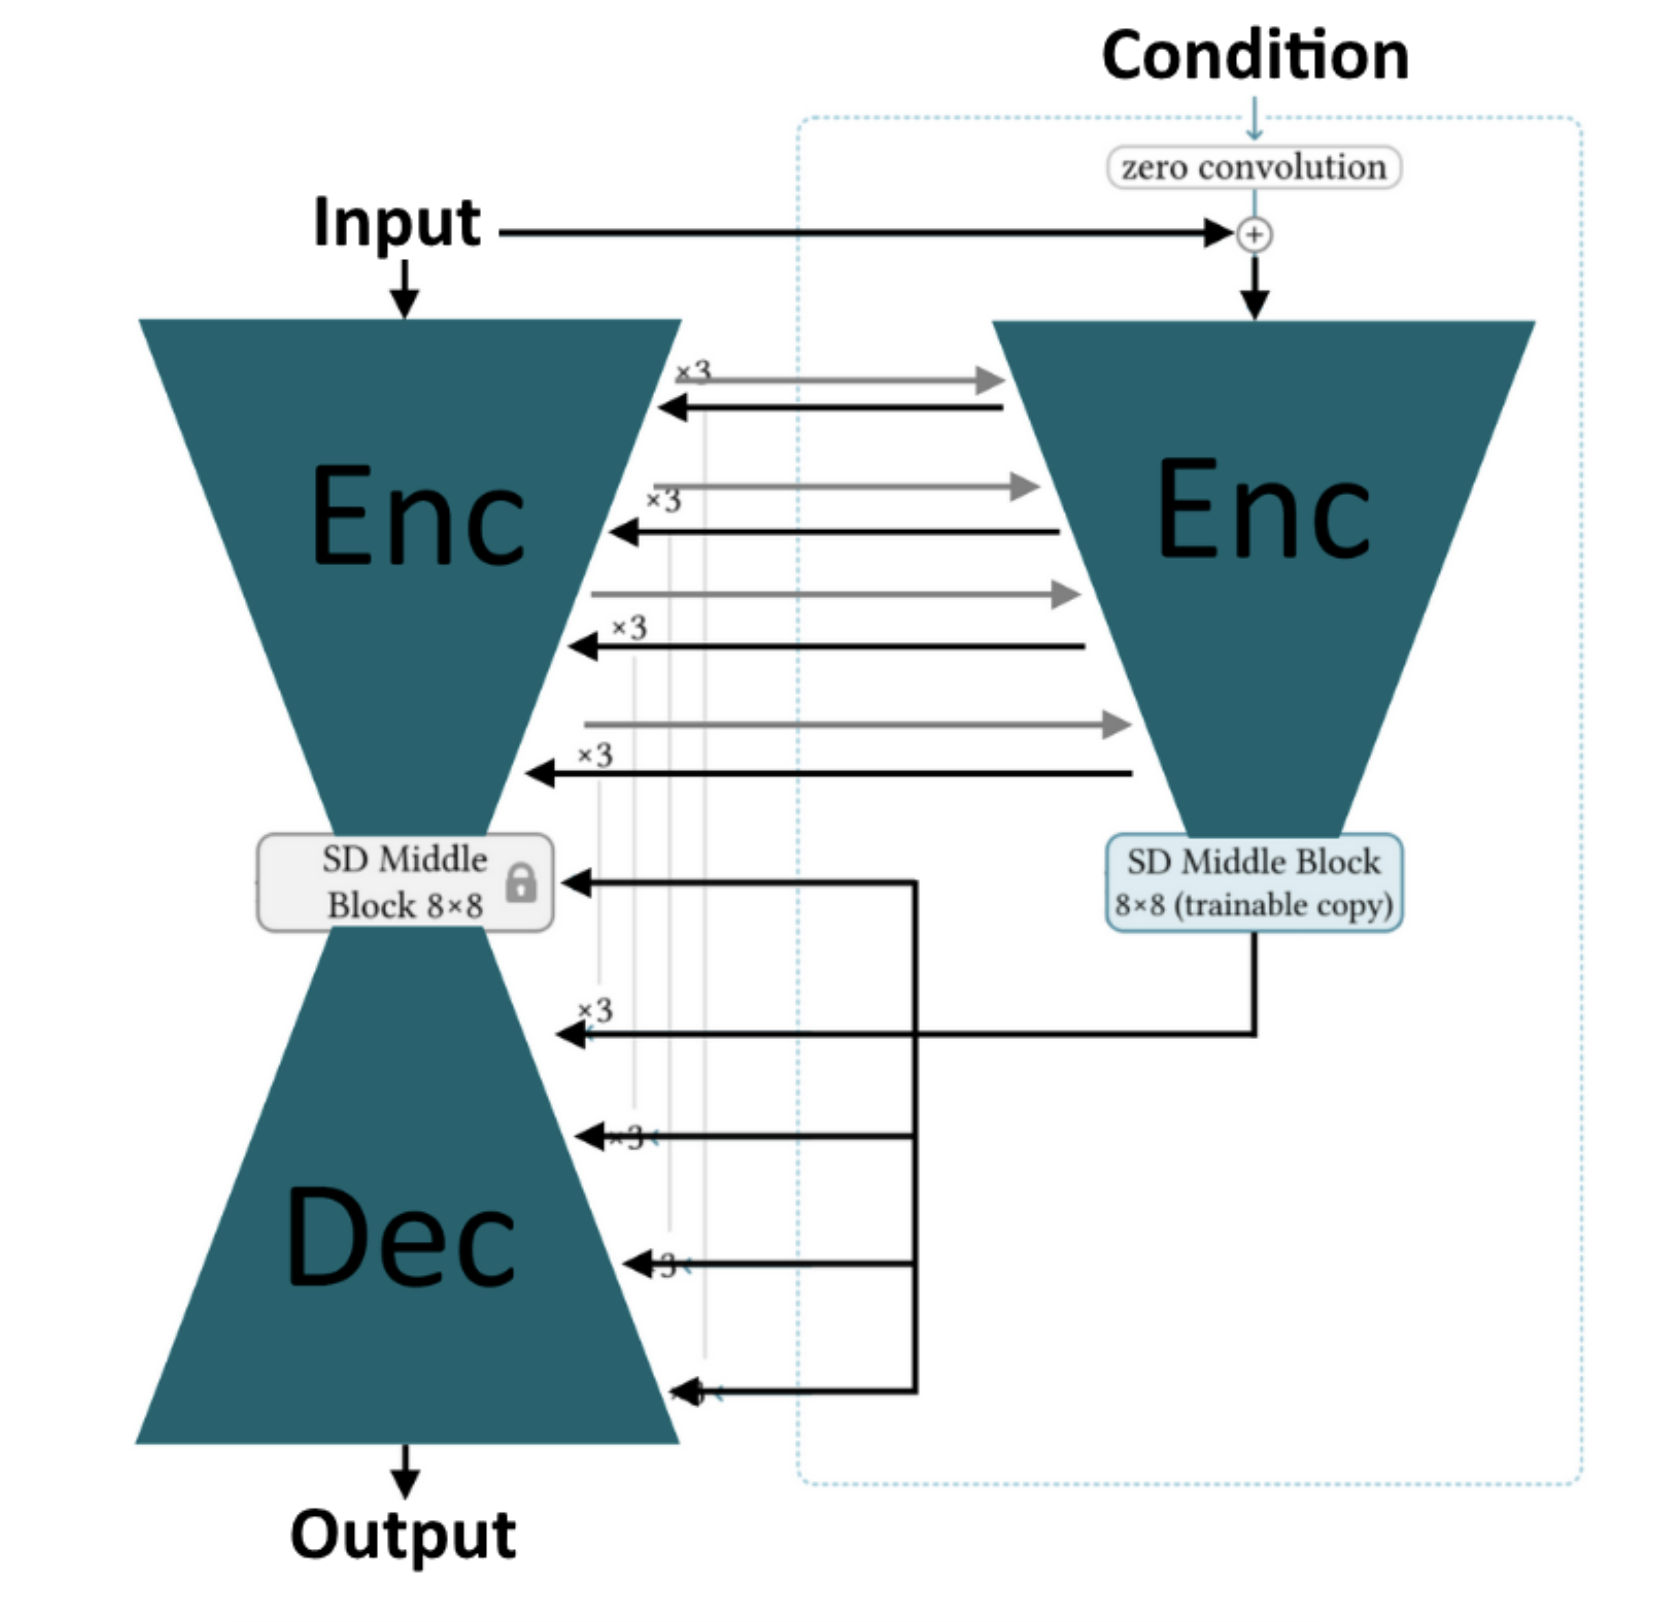

We have `9=3*3` connections encoder connections, `1` mid connection and `8+1=9=3*3` decoder connections.

So, unlike in the picture, we don't have 4 up/down steps, but only 3.<br/>
Also, in the encoder, we only connect from base to control, not also from control to base. This is likely due to the params we fixed at the beginning to make the analysis easier.

The init of `TwoStreamControlNet` also has a part for propagating "hints". **Q:** What are hints in this context?

    self.input_hint_block = TimestepEmbedSequential(
        conv_nd(dims, hint_channels, 16, 3, padding=1),
        nn.SiLU(),
        conv_nd(dims, 16, 16, 3, padding=1),
        nn.SiLU(),
        conv_nd(dims, 16, 32, 3, padding=1, stride=2),
        nn.SiLU(),
        conv_nd(dims, 32, 32, 3, padding=1),
        nn.SiLU(),
        conv_nd(dims, 32, 96, 3, padding=1, stride=2),
        nn.SiLU(),
        conv_nd(dims, 96, 96, 3, padding=1),
        nn.SiLU(),
        conv_nd(dims, 96, 256, 3, padding=1, stride=2),
        nn.SiLU(),
        zero_module(conv_nd(dims, 256, int(model_channels * control_model_ratio), 3, padding=1))
    )

### Okay! Now, let's look at how forward is one

In [ ]:
def forward(x: torch.Tensor, t: torch.Tensor, c: dict, hint: torch.Tensor, **kwargs) -> torch.Tensor:
    x = torch.cat((x, c.get("concat", torch.Tensor([]).type_as(x))), dim=1)
    if x.size(0) // 2 == hint.size(0): hint = torch.cat([hint, hint], dim=0) # for classifier free guidance
    return forward_(x, timesteps=t, context=c.get("crossattn", None), y=c.get("vector", None), hint=hint, base_model=diffusion_model, compute_hint=False, **kwargs)

def forward_(x, hint, timesteps, context, base_model=None, y=None, precomputed_hint=False, no_control=False, compute_hint=False, **kwargs):
    if base_model is None: base_model = diffusion_model
    if no_control: return base_model(x=x, timesteps=timesteps, context=context, y=y, **kwargs)

    t_emb = timestep_embedding(timesteps, model_channels, repeat_only=False)
    if learn_embedding: emb = control_model.time_embed(t_emb) * control_scale ** 0.3 + base_model.time_embed(t_emb) * (1 - control_scale ** 0.3)
    else: emb = base_model.time_embed(t_emb)

    if y is not None: emb = emb + base_model.label_emb(y)

    if precomputed_hint: guided_hint = hint
    else: guided_hint = input_hint_block(hint, emb, context)

    h_ctr = h_base = x
    hs_base, hs_ctr = [], []
    it_enc_convs_in, it_enc_convs_out, it_dec_convs_in, it_dec_convs_out = map(iter, (enc_zero_convs_in, enc_zero_convs_out, dec_zero_convs_in, dec_zero_convs_out))
    scales = iter(scale_list)

    ###################### Cross Control ######################
    # input blocks (encoder)
    for module_base, module_ctr in zip(base_model.input_blocks, control_model.input_blocks):
        h_base = module_base(h_base, emb, context)
        h_ctr = module_ctr(h_ctr, emb, context)
        if guided_hint is not None:
            h_ctr = h_ctr + guided_hint
            guided_hint = None
        hs_base.append(h_base)
        hs_ctr.append(h_ctr)
        h_ctr = th.cat([h_ctr, next(it_enc_convs_in)(h_base, emb)], dim=1)
    # mid blocks (bottleneck)
    h_base = base_model.middle_block(h_base, emb, context)
    h_ctr = control_model.middle_block(h_ctr, emb, context)
    h_base = h_base + middle_block_out(h_ctr, emb) * next(scales)
    # output blocks (decoder)
    for module_base in base_model.output_blocks:
        h_base = h_base + next(it_dec_convs_out)(hs_ctr.pop(), emb) * next(scales)
        h_base = th.cat([h_base, hs_base.pop()], dim=1)
        h_base = module_base(h_base, emb, context)

    return base_model.out(h_base)

Cool! The forward is exactly how I thought it'd be.